# Demonstration of SFILES 2.0 &harr; flowsheet graph conversion

### Example 1

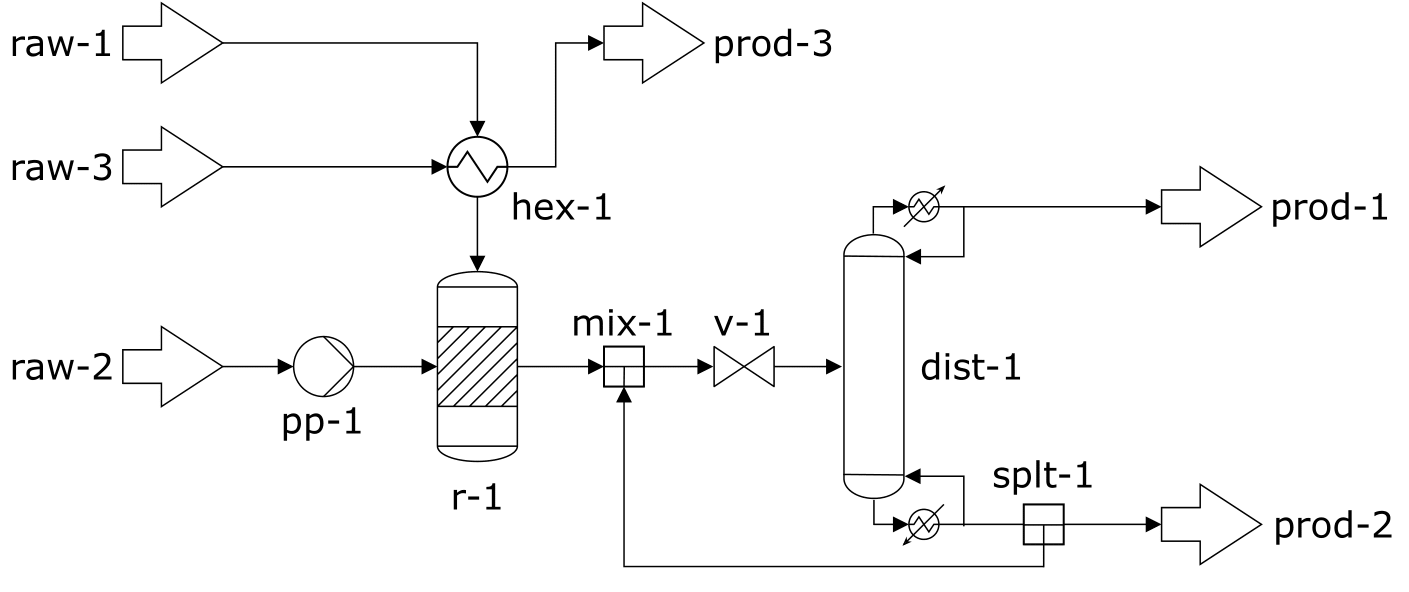

In [1]:
from IPython.display import Image
Image(filename='examples/Flowsheet_theory-1.png') 

How to create graph: 
- add all unit operations as nodes with numbered name (refer to standardized names in paper)
- add all stream connections as edges. ('labels' is optional, 'tags' should be used as described in paper).   
Format:  ('node-1', 'node-2', {'labels': 'streamlabel', 'tags':{'col': [<'tout','tin','bout','bin'>], 'he': [<'x_in','x_out'>]}})

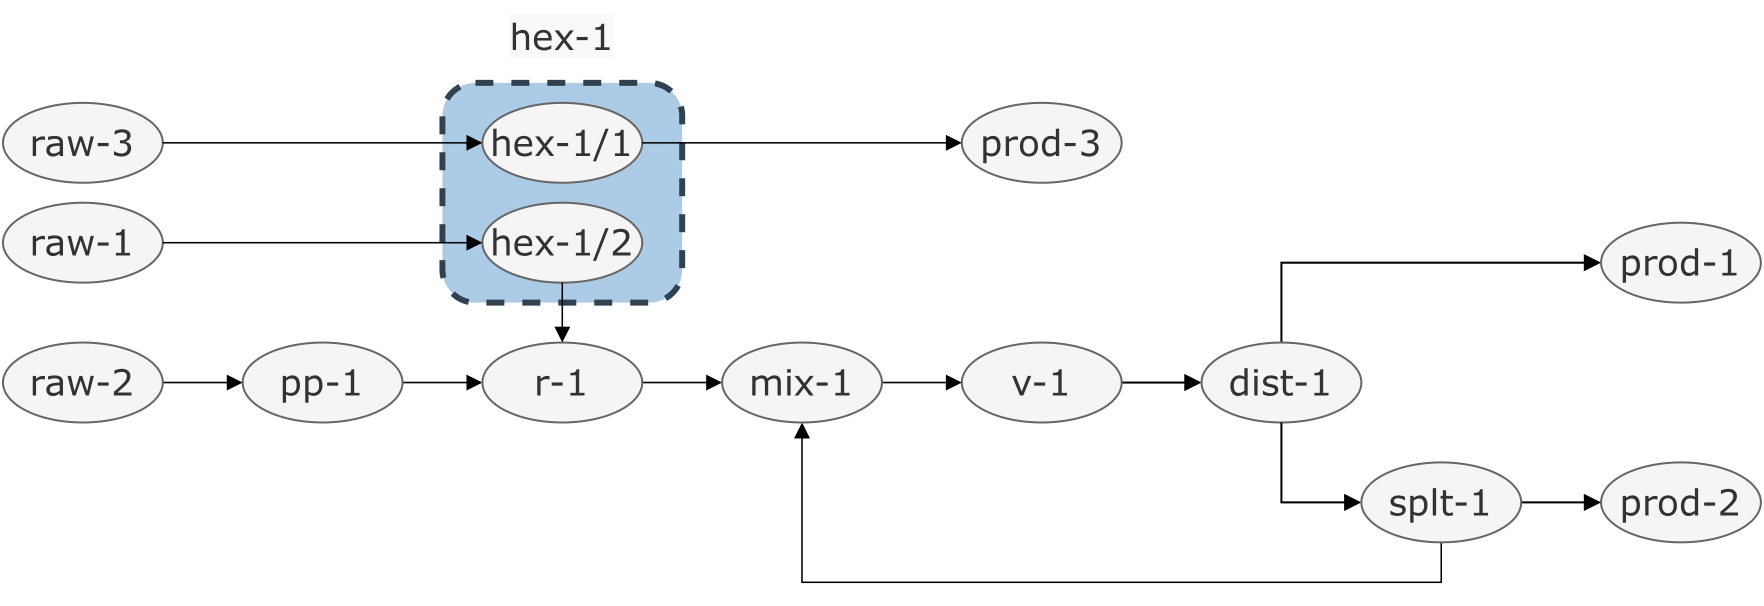

In [2]:
# How the graph should look like in theory:
Image(filename='examples/graph_theory-1.png') 

In [3]:
# How to construct graph with code:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from([
    'raw-1', 'raw-2', 'hex-1', 'pp-1', 'r-1', 'mix-1', 'v-1', 
    'dist-1', 'splt-1', 'prod-1', 'prod-2', 'prod-3', 'raw-3'
    ])
G.add_edges_from([
    ('raw-1', 'hex-1',{'labels': '', 'tags':{'he': ['1_in']}}),
    ('hex-1', 'r-1', {'labels': '', 'tags':{'he': ['1_out']}}), 
    ('raw-2', 'pp-1'), ('pp-1', 'r-1'), ('r-1', 'mix-1'), ('mix-1', 'v-1'), ('v-1', 'dist-1'),
    ('dist-1', 'prod-1', {'tags':{'col': ['tout']}}),
    ('dist-1', 'splt-1', {'tags':{'col': ['bout']}}), 
    ('splt-1','mix-1'), ('splt-1', 'prod-2'), 
    ('raw-3', 'hex-1',{'labels': '', 'tags':{'he': ['2_in']}}), 
    ('hex-1', 'prod-3',{'labels': '', 'tags':{'he': ['2_out']}})
    ])

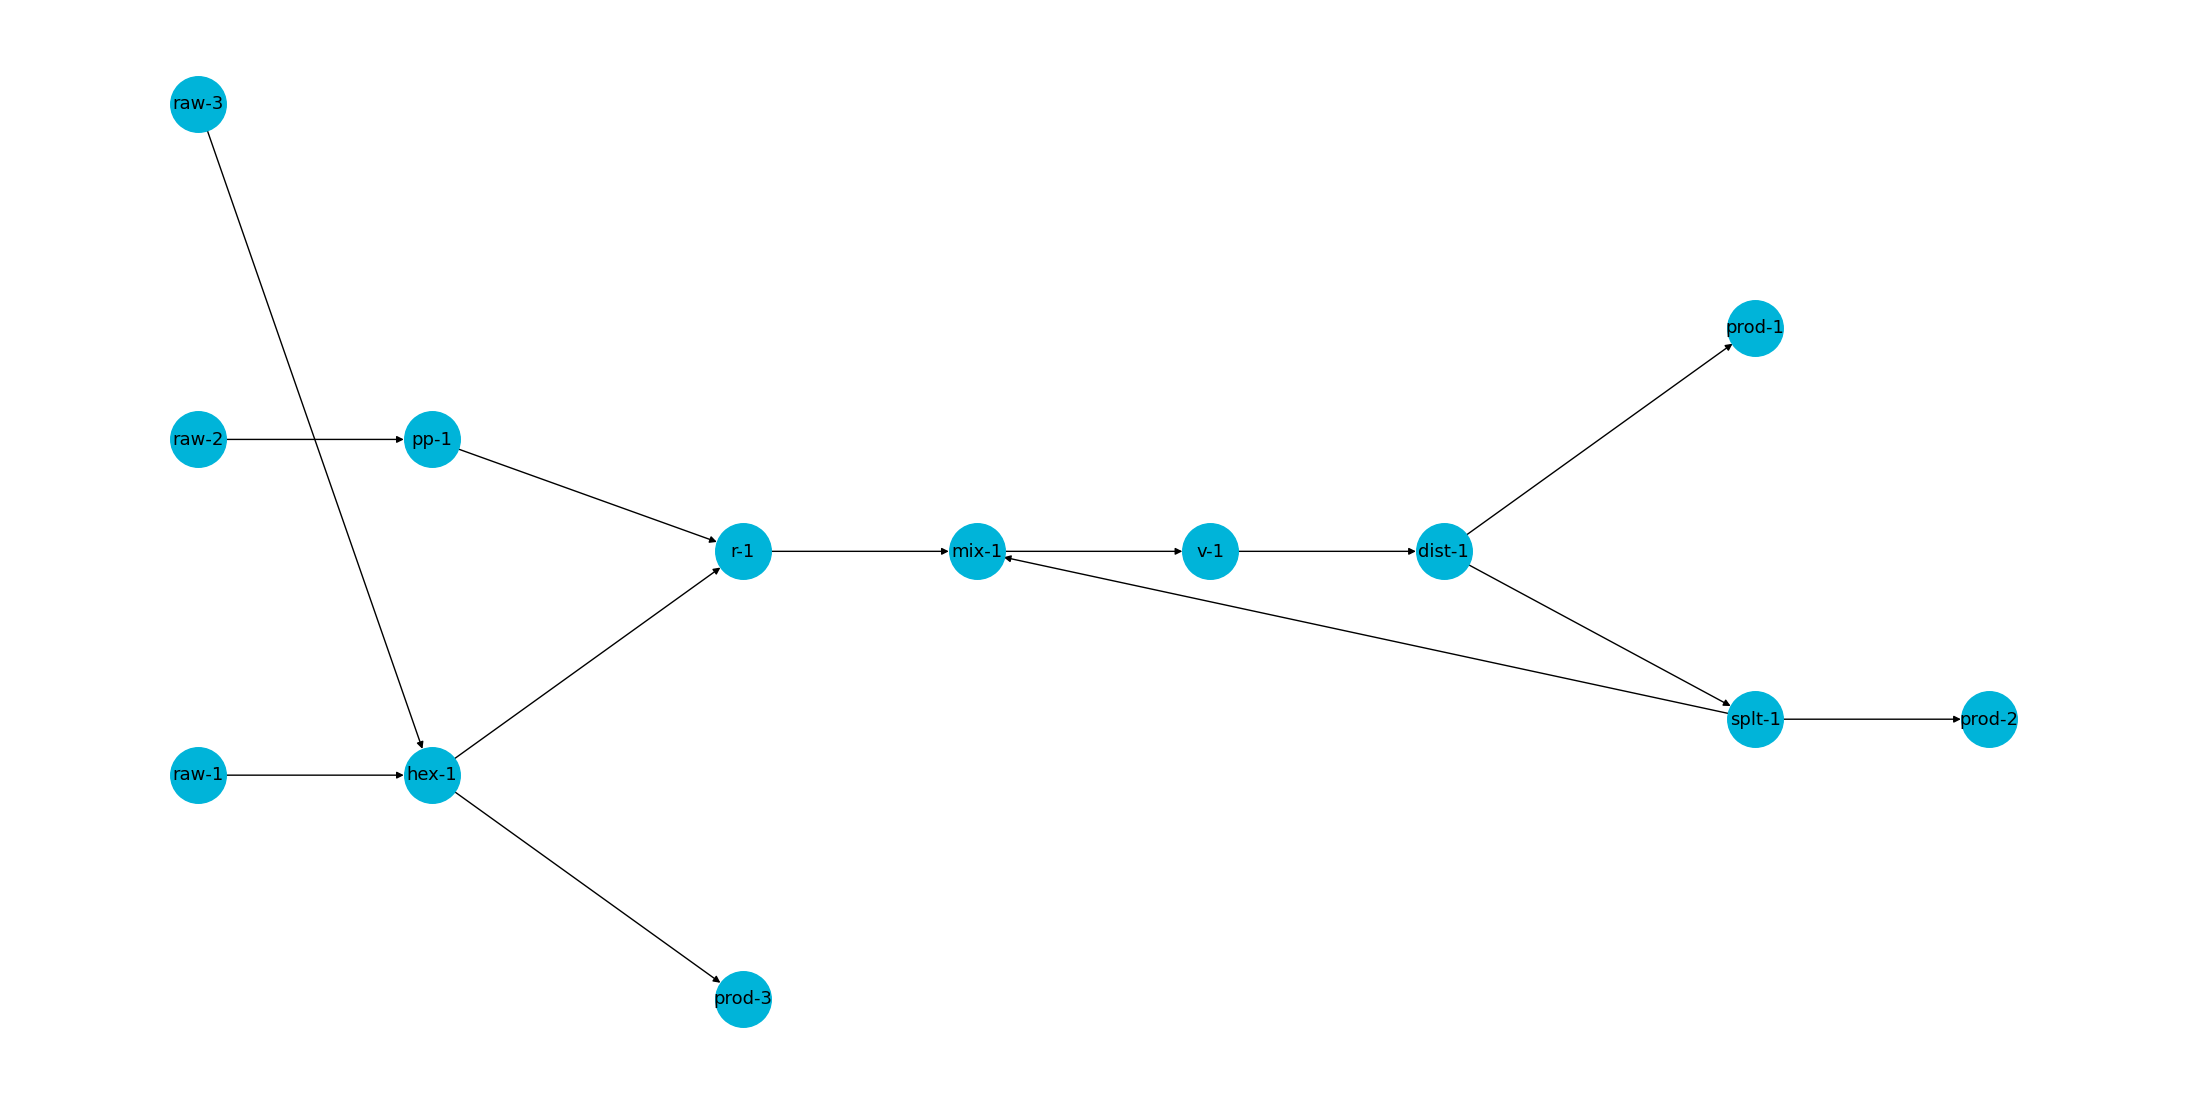

(<Figure size 2166.67x1083.33 with 1 Axes>, None, None)

In [4]:
# Save graph as flowsheet class object.
from Flowsheet_Class.flowsheet import Flowsheet
flowsheet_1=Flowsheet()
flowsheet_1.state=G
flowsheet_1.visualize_flowsheet(table=False, pfd_path='plots/flowsheet1', plot_with_stream_labels=False)


In [5]:
# Create SFILES from graph using the flowsheet class.
flowsheet_1.convert_to_sfiles(version='v2')
sfiles_1 = flowsheet_1.sfiles
print(sfiles_1)
flowsheet_1.create_from_sfiles(sfiles_1, overwrite_nx=True)
flowsheet_1.convert_to_sfiles(version='v2')
sfiles_2 = flowsheet_1.sfiles
print('Conversion from SFILES to graph and back to SFILES successful!' if sfiles_1 == sfiles_2
      else 'Error encountered during conversion!')

(raw)(hex){1}(r)<&|(raw)(pp)&|(mix)<1(v)(dist)[{tout}(prod)]{bout}(splt)1(prod)n|(raw)(hex){1}(prod)
Conversion from SFILES to graph and back to SFILES successful!


# Real flowsheet examples (extracted from DWSIM simulation files)

In [6]:
from os import listdir
from os.path import isfile, join
all_files = {i:f for i,f in enumerate(listdir('Real_flowsheets/DWSim_pickle_files')) if isfile(join('Real_flowsheets/DWSim_pickle_files', f))}
all_images = {i:f for i,f in enumerate(listdir('Real_flowsheets/images')) if isfile(join('Real_flowsheets/images', f))}
    

In [7]:
import re
all_sfiles = {}
for i,f in all_files.items():
    # Read pickle files and restructure names.
    G = nx.read_gpickle(join('Real_flowsheets/DWSim_pickle_files', f) )
    _node_names = list(G.nodes)
    relabel_mapping = {}
    for n in _node_names:
        r = re.compile("([a-zA-Z]+)([0-9]+)")
        _full_name = r.match(n).groups()
        _name = _full_name[0]  # Name without number
        _num = _full_name[1]
        relabel_mapping[n] = _name +'-'+ _num
    G = nx.relabel_nodes(G, relabel_mapping)

    # Load graph as flowsheet class object
    flowsheet = Flowsheet(OntoCapeConformity=True)
    flowsheet.state = G
    # Convert to sfiles (+ -> graph -> sfiles)
    flowsheet.convert_to_sfiles(version='v2', remove_hex_tags=True)
    sfiles_1 = flowsheet.sfiles
    all_sfiles[i]=sfiles_1
    flowsheet.create_from_sfiles(overwrite_nx=True, merge_HI_nodes=False)
    flowsheet.convert_to_sfiles(version='v2', remove_hex_tags=True)
    sfiles_2 = flowsheet.sfiles
    print('%i: Conversion from SFILES to graph and back to SFILES successful!' % i if sfiles_1 == sfiles_2
      else '%iError encountered during conversion!' % i)

0: Conversion from SFILES to graph and back to SFILES successful!
1: Conversion from SFILES to graph and back to SFILES successful!
2: Conversion from SFILES to graph and back to SFILES successful!
3: Conversion from SFILES to graph and back to SFILES successful!
4: Conversion from SFILES to graph and back to SFILES successful!
5: Conversion from SFILES to graph and back to SFILES successful!
6: Conversion from SFILES to graph and back to SFILES successful!
7: Conversion from SFILES to graph and back to SFILES successful!
8: Conversion from SFILES to graph and back to SFILES successful!


## Flowsheet images and SFILES 2.0 from simulation files

Comments:
- Initial node for flowsheet graph traversal (first raw node in SFILES 2.0 string) is marked red in image.
- Example Natural gas processing: First flash bottom outlet was zero in simulation file and is not stored as prod node
in graph
- Modify i in range [0,8] to look at 9 different examples

NaturalGasProcessing
(raw)(hex)(flash){tout}(hex)(flash)[{tout}(turb)(flash)[{bout}(hex)(mix)<2(hex)(dist)[{bout}(dist)[{tout}(prod)]{bout}(dist)[{bout}(prod)]{tout}(prod)]{tout}(mix)<1(hex)(comp)(comp)(prod)]{tout}(hex)1]{bout}(hex)2


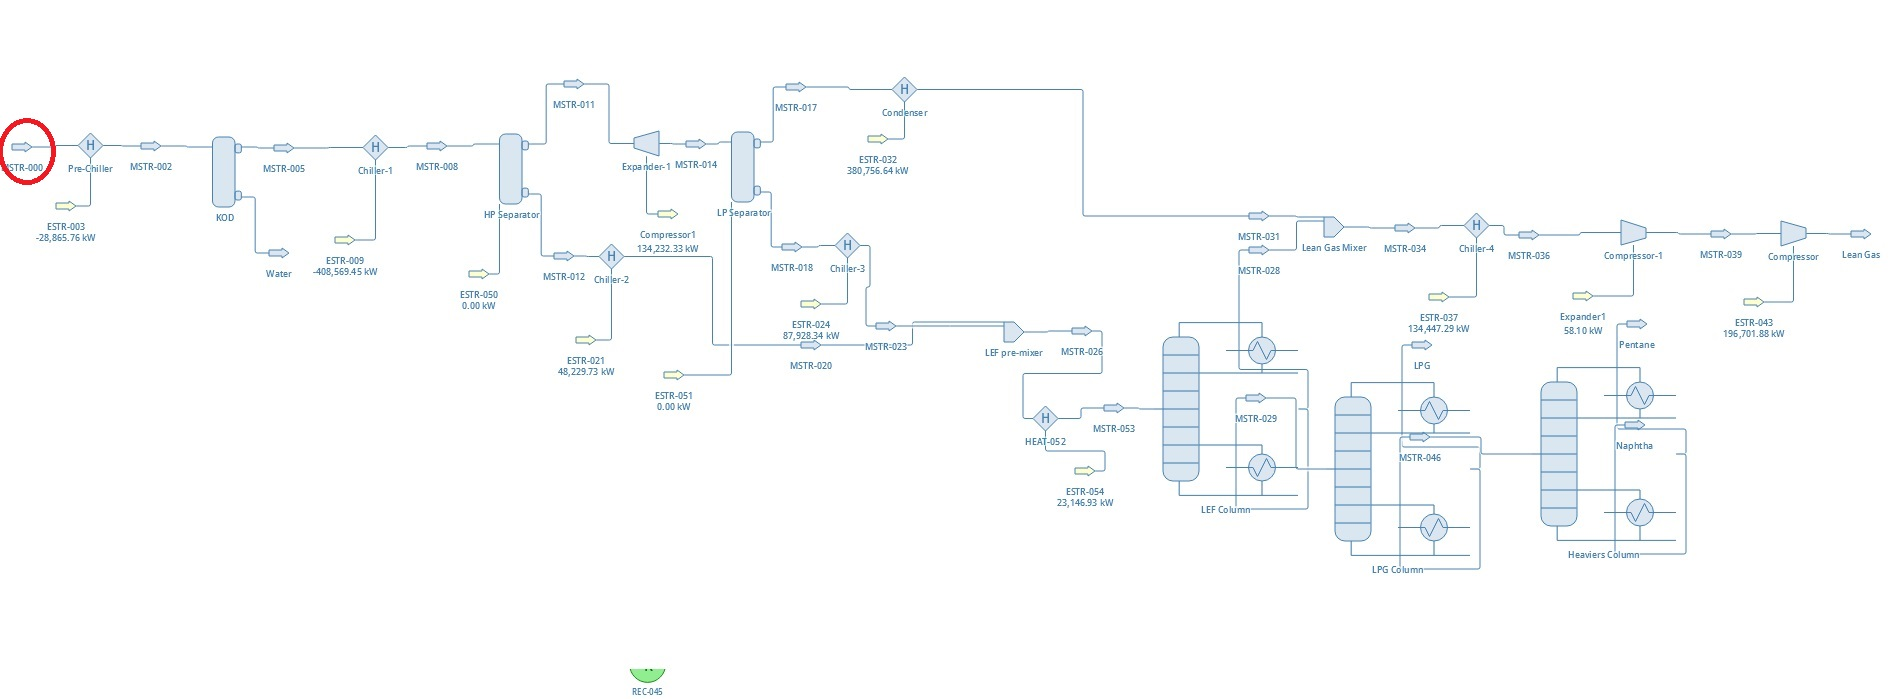

In [8]:
i=0
# Name
print('_'.join(all_files[i].split(sep='_')[2:]).split(sep='.')[0])
# SFILES
print(all_sfiles[i])
# Image
Image(filename=join('Real_flowsheets/images',all_images[i]))

# Example including control structure

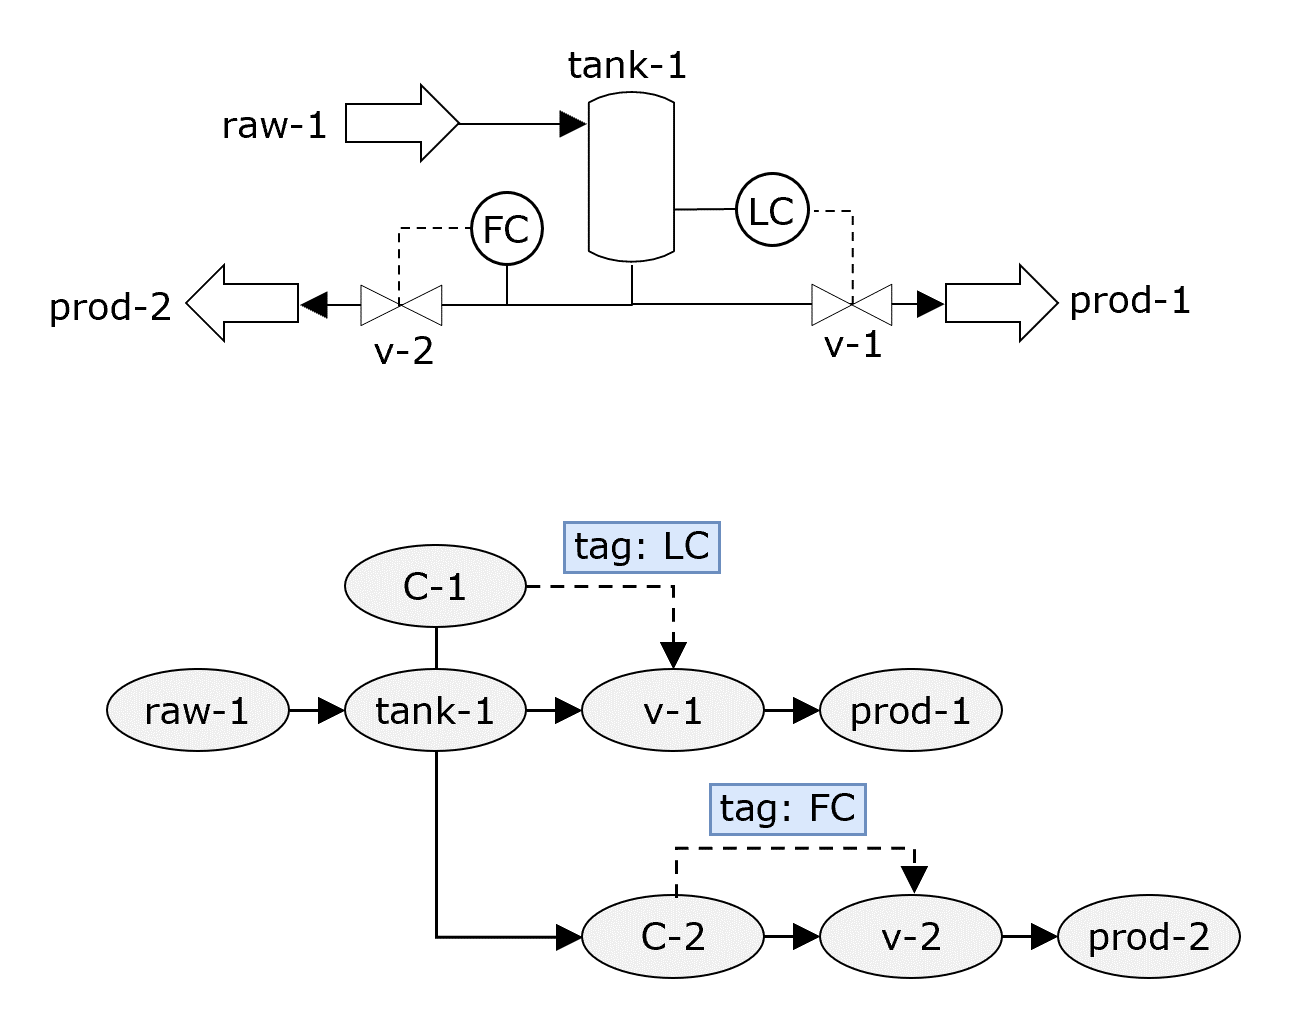

In [9]:
from IPython.display import Image

Image(filename='examples/SFILESctrl_example.png')

Comments:
- Edges are added to networx graph.
- The letter code of the control instruments is contained in their node name, e.g.,
C-1/TIC.
- Signal connections/edges are indicated by the tag 'signal' in 'tags'. Since networkx DiGraph does not allow multiple
connection between two nodes in the same direction, these nodes are distinguished by the attribute of 'signal'.
- Signal connections leading directly to the next unitoperation, are tagged with 'next_unitop'. In the example, this is
the case for the connection between C-2/FC and v-2. Here, material stream and signal edge are in
- Every other signal connection is tagged with 'not_next_unitop'.

In [10]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from([
    ('raw-1', 'tank-1'), ('tank-1', 'C-1/LC'), ('tank-1', 'v-1'), ('v-1', 'prod-1'), ('tank-1', 'C-2/FC'),
    ('C-2/FC', 'v-2', {'tags':{'signal': ['next_unitop']}}), ('v-2', 'prod-2'),
    ('C-1/LC', 'v-1', {'tags':{'signal': ['not_next_unitop']}})])


In [11]:
# Save graph as flowsheet class object.
from Flowsheet_Class.flowsheet import Flowsheet

flowsheet_ctrl = Flowsheet()
flowsheet_ctrl.state = G

# Create SFILES from graph using the flowsheet class.
flowsheet_ctrl.convert_to_sfiles(version='v2')
sfiles_1 = flowsheet_ctrl.sfiles
print(sfiles_1)
flowsheet_ctrl.create_from_sfiles(sfiles_1, overwrite_nx=True)
flowsheet_ctrl.convert_to_sfiles(version='v2')
sfiles_2 = flowsheet_ctrl.sfiles
print('Conversion from SFILES to graph and back to SFILES successful!' if sfiles_1 == sfiles_2
      else 'Error encountered during conversion!')


(raw)(tank)[(C){LC}_1][(v)<_1(prod)](C){FC}_2(v)<_2(prod)
Conversion from SFILES to graph and back to SFILES successful!
